# Scania Database : Histograms

The database was released in 2016 at the IDA conference and is available on UCI. It contains anonymised data from an Air Pressure System (APS), with the target of detecting future failures.

To avoid confusion, during this note, we will use the following norm:
- positive classification or class 1 means there is component failures of specific components of the APS system.
- negative classification or class 0 means there is a failure but not related to the APS

All the feature are positive integers :
- 100 are "counters" that counts the occurrence of events known by a two-letter code.
- 7 "histograms" of 10 bins, which means that here this is a counting of a particular physical value being in a particular range (also known as "bucket").

We do not know what those are or the values of the ranges, but the presentation of the paper suggest they are open-ended.

The 7 histograms of physical histograms are known as AG, AY, AZ, BA, CN, CS and EE.

The aim of the code below is to better understand those histograms.

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter, FuncFormatter
import matplotlib.patches as mpatches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

def pre_processing(df,value_for_na = -1):
    df["class"] = df["class"].map({"neg":0,"pos":1})
    df = df.replace("na",value_for_na)
    for col in df.columns:
        if col != "origin":
            df[col] = pd.to_numeric(df[col])
    return df

def get_tag(name):
    return name.split("_")[0]

['aps_failure_training_set.csv', 'aps_failure_test_set_processed_8bit.csv', 'aps_failure_training_set_processed_8bit.csv', 'aps_failure_description.txt', 'aps_failure_test_set.csv']


In [17]:
train = pd.read_csv('../input/aps_failure_training_set.csv',)
test = pd.read_csv('../input/aps_failure_test_set.csv',)
train["origin"] = "train"
test["origin"] = "test"
data= pd.concat([train,test],sort=True)
#to avoid double index
data = data.reset_index()

In [18]:
columns_list = train.columns

all_columns_with_tags = [a for a in columns_list if "_" in a]
all_tags = [get_tag(a) for a in all_columns_with_tags]
hists = [k for k,v in Counter(all_tags).items() if v == 10]
hists_columns = [k for k in all_columns_with_tags if get_tag(k) in hists]
hists_dict = {k:[col for col in hists_columns if k in col] for k in hists if get_tag(k) in hists}
counter_columns = [k for k in all_columns_with_tags if get_tag(k) not in hists]

In [19]:
data = pre_processing(data,-1)
data = data.rename(columns={"class":"Class"}) #to avoid name collision with the class



## The histograms

There are 860 missing values, but when there is a missing value in a histogram, all the values in the histograms are missing.

First let's have a look at ten histograms, five from the positive class and five from the negative class.


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


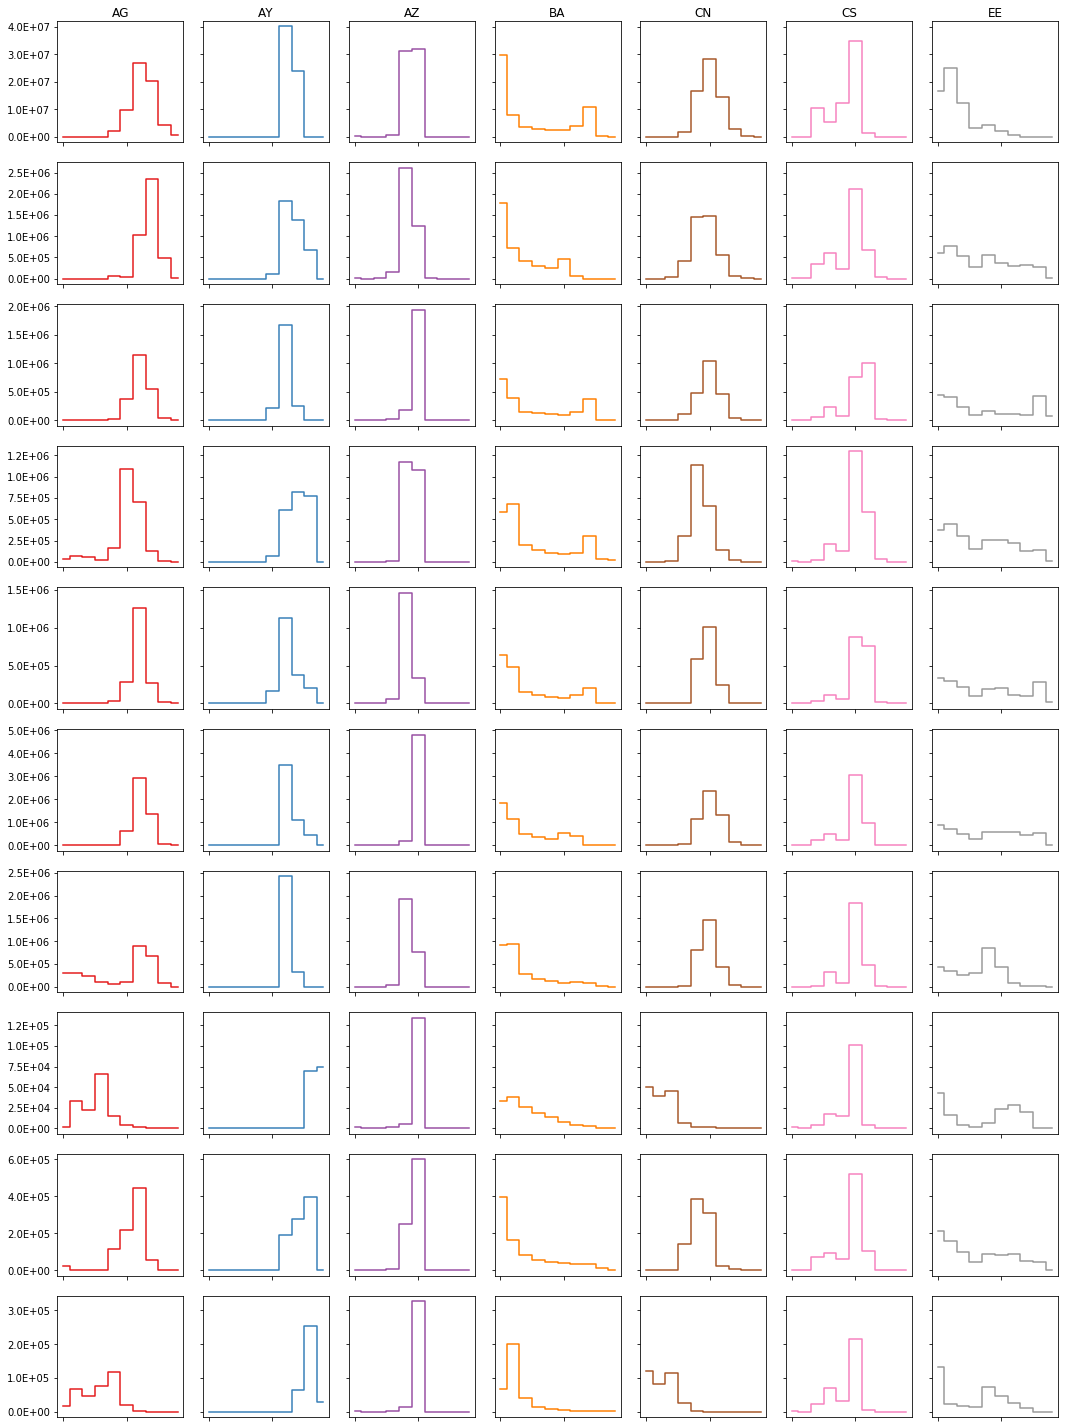

In [20]:
fig , axs = plt.subplots(10,7,sharex=True,  sharey='row',figsize=(15,20))
cmap=plt.cm.get_cmap('Set1', 7)
df_top = data[(data.Class==0)&(data.ag_000>0)]
for axis,r in zip(axs,df_top.sample(5).iterrows()):
    for i,(ax,hist) in enumerate(zip(axis,hists)):
        ax.step(range(10),r[1][f"{hist}_000":f"{hist}_009"],where="mid",color=cmap(i))
        ax.tick_params(labelbottom=False)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "%.1E"%x))
        ax.tick_params(axis='y', which='major', labelsize=10)
df_bottom = data[(data.Class==1)&(data["ag_000"]>0)]
for axis,r in zip(axs[5:],df_top.sample(5).iterrows()):
    for i,(ax,hist) in enumerate(zip(axis,hists)):
        ax.step(range(10),r[1][f"{hist}_000":f"{hist}_009"],where="mid",color=cmap(i))
        ax.tick_params(labelbottom=False)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "%.1E"%x))
        ax.tick_params(axis='y', which='major', labelsize=10)

for ax,hist in zip(axs[0],hists):
    ax.set_xlabel(hist.upper())    
    ax.xaxis.set_label_position('top') 
plt.tight_layout()


## Histogram features

When looking at the histograms, we notice they have the same surface. Indeed if we add the histograms values for each measurement that are the same (when there are not missing).

This means that all measurements are taken at the same moment.

This is also a way to measure the age of the APS .

We add a feature called 'system_age' that is the sum for features for one of the histograms (they are in practice equal).

Now let's look at the distribution of this "system_age" feature depending on whether the system is failing or sound.

Apart from a group of APS that have no measurements, we notice that failing systems have more measures than none failing system. Assuming the frequency for those measurements is the same across systems, this means that failing systems tend to be older systems.

The graph is scaled to have the same surface, we cannot compare the value between the figure, but we can already notice that the system that fails are usually older than "younger" system which should not come are a surprise.


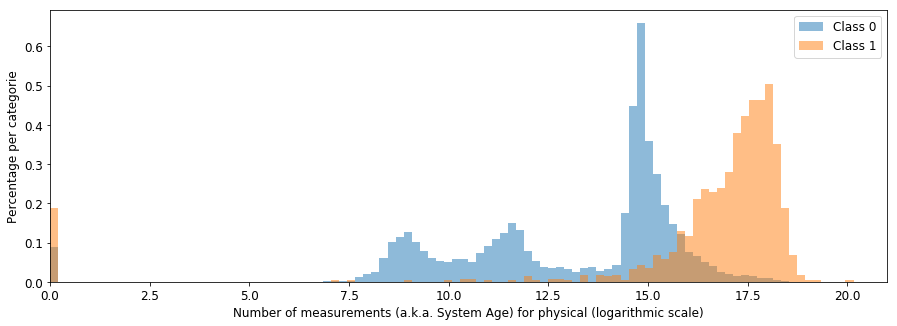

In [21]:
for hist in hists:
    data[f"{hist}_total"] = sum(data[col] for col in hists_dict[hist])
data["system_age"] = data[[f"{hist}_total" for hist in hists]].max(axis=1)
data = data.replace(-10,-1) #Some totals of -1 to make it easy to detect NA
#data = data.drop([f"{hist}_total" for hist in hists],axis=1)


plt.figure(figsize=(15,5));
for_plotting = data[data.system_age>=0]
_,bins,_ = plt.hist(np.log(for_plotting[for_plotting.Class==0].system_age+1),bins=100,density=True,alpha=0.5,label="Class 0");
plt.hist(np.log(for_plotting[for_plotting.Class==1].system_age+1),bins=bins,density=True,alpha=0.5,label="Class 1");
plt.legend();
plt.ylabel("Percentage per categorie");
plt.xlabel("Number of measurements (a.k.a. System Age) for physical (logarithmic scale)");
plt.xlim(0,21);





## Distribution of the measurements

To make the graph readable, it has been scaled using the width.

There is the same number of points per categories; this means that when there is a spike, this does not mean that there is fewer values, but that all values are the same.

This means that for class 0, they are as many points for ay_000 and ay_008, but almost ay_00 values are 0.

Also given the range of the distribution for the number of occurrence in each category, the number of events is using a logarithmic scale.

For example, we notice some distribution difference between the class for the variables ag_002 and cn_002; we will zoom in into those 2 features.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


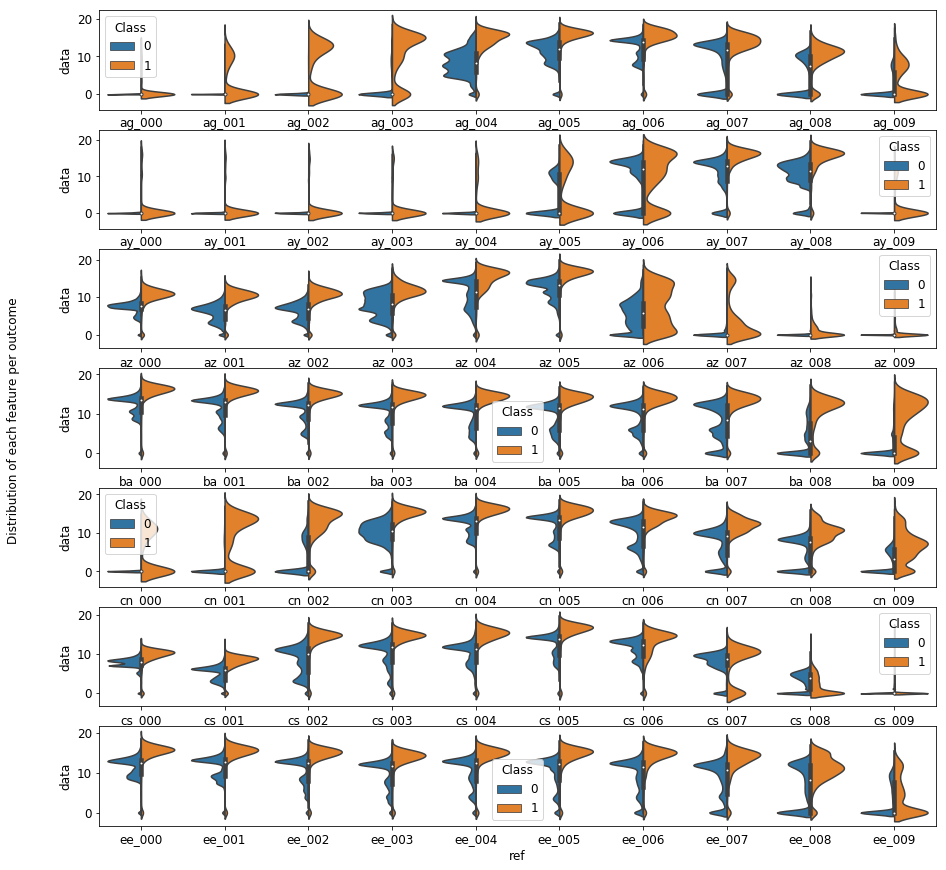

In [22]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
df_dist = {}
for dist in hists:
    pds_to_concat = []
    for i,col in enumerate(hists_dict[dist]):
        temp = data[[col,'Class']]
        temp["ref"] = col
        temp.loc[temp[col]>=0,col] = np.log(temp[col]+1)
        temp.columns = ["data","Class","ref"]
        pds_to_concat.append(temp)
    df_dist[dist] = pd.concat(pds_to_concat)
    df_dist[dist] = df_dist[dist][df_dist[dist].data>=0] # No NA values
#ag_dist.data = np.log(ag_dist.data+1)
fig , axs = plt.subplots(7)
fig.set_figheight(15)
fig.set_figwidth(15)
#sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
for i,hist in enumerate(hists):
    sns.violinplot(data=df_dist[hist],x="ref",y="data",hue="Class",scale="width",scale_hue=True
                   , split=True,ax=axs[i],legend=(i==0));
fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');




## Feature AG_002 distribution

Let's look at the variation of the failure rate depending of the number of occurence of AG_002.

First we select all the system for which there is no occurence of AG in the range 2 (the thirds range), said differently those are the system for which AG_002 is 0.

They represent in practice the majority of the system.

The of the APS are divided in 20 buckets of equal size (200 each).

The percentage of failure goes from a few percent for the lower values, to more than 90\% for the top 200 values.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


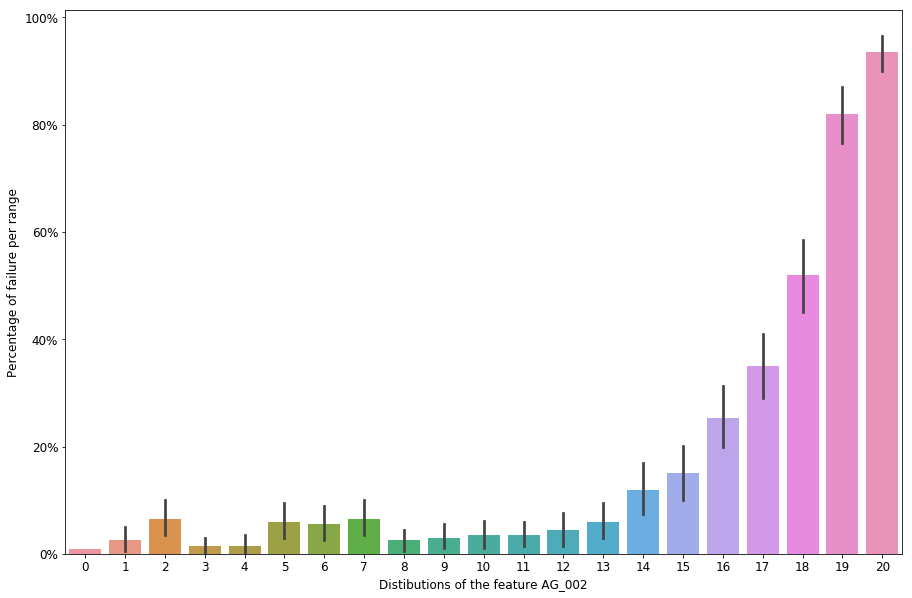

In [23]:
variable =  "ag_002"
bucket_nb = 20 

_ , bins = pd.qcut(np.log(data[data[variable]>0][variable]),bucket_nb,retbins=True)
data[f"{variable}_buckets"] = pd.cut(np.log(data[variable]+1),[-0.1] + list(bins),labels=range(bucket_nb+1))
#pd.crosstab(data[f"{variable}_buckets"],data.Class,margins=True)
plt.figure(figsize=(15,10));
ax = sns.barplot(data=data,x=f"{variable}_buckets", y="Class")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Distibutions of the feature AG_002");
plt.ylabel("Percentage of failure per range");



## Feature CN_001 distribution

We will do the same with the same with the feature CN_001.

First, we select all the system for which there is no occurrence of CN in the range 1 (the second interval), said differently those are the system for which CN_001 is 0.

They represent in practice the majority of the systems here again.

The rest of the APS are divided into 20 buckets of equal size (200 each).

The percentage of failure goes from a few percents for the lower values to more than 70\% for the top 200 values, still very useful for detecting failing system but not as precise as AG_002.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


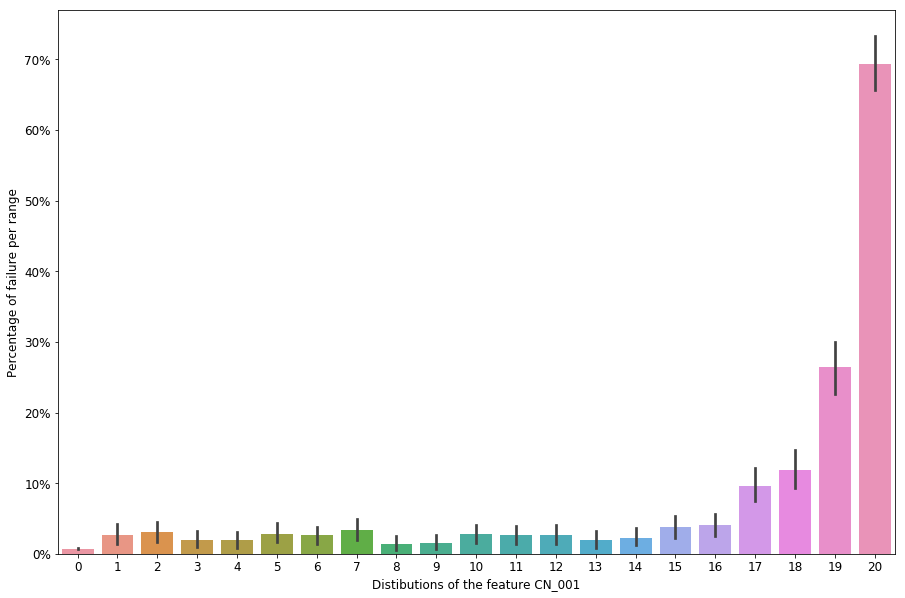

In [24]:
variable =  "cn_001"
bucket_nb = 20 
_ , bins = pd.qcut(np.log(data[data[variable]>0][variable]),bucket_nb,retbins=True)
data[f"{variable}_buckets"] = pd.cut(np.log(data[variable]+1),[-0.1] + list(bins),labels=range(bucket_nb+1))
#pd.crosstab(data[f"{variable}_buckets"],data.Class,margins=True)
plt.figure(figsize=(15,10));
ax = sns.barplot(data=data,x=f"{variable}_buckets", y="Class")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Distibutions of the feature CN_001");
plt.ylabel("Percentage of failure per range");




## Potential interaction between AG_002 and CN_001

We have looked at the potential of using AG_002 and CN_001 for detecting failing system, not let's look at the possibility of looking at those 2 variables at the same time.

Given the distribution of AG_002 and CN_001, the diagramme below is also using a logarithmic scale for both AG_002 ad CN_001.

In different of blue is the "sound" system.

In the different red is the failing system.

When you have a red cell, you have a majority of class 1 APS.


/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


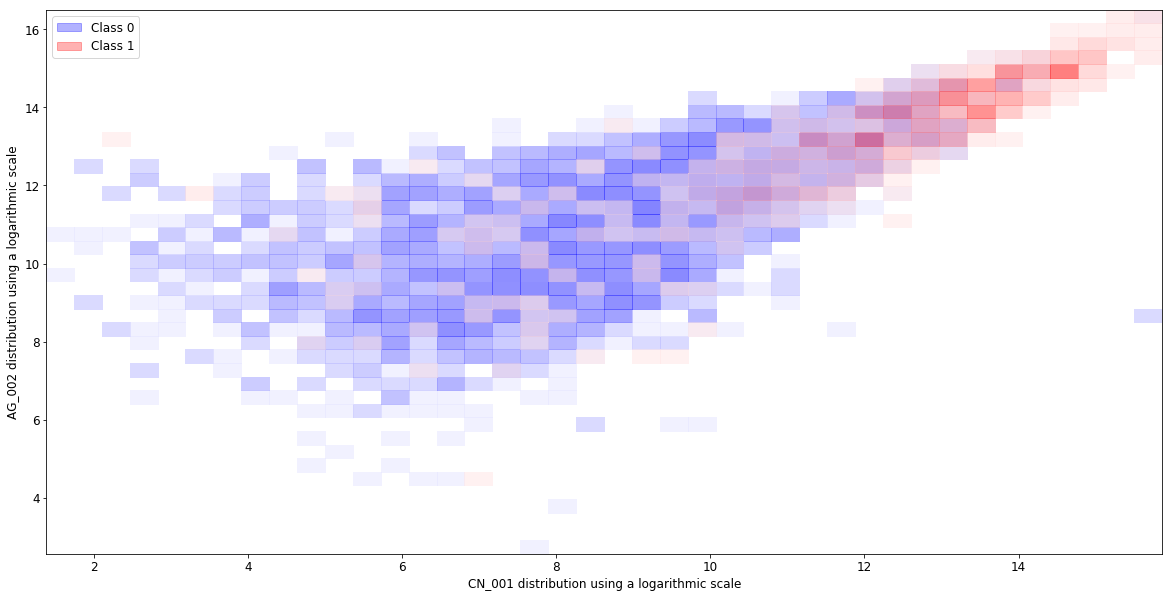

In [25]:


plt.figure(figsize=(20,10))

df = data[(data.Class==0)&(data.ag_002>0)&(data.cn_001>0)]
cmap = sns.light_palette("blue", as_cmap=True)
_,xedges,yedges, _ = plt.hist2d(np.log(df["ag_002"]+2), np.log(df["cn_001"]+1),norm=LogNorm()
                                , bins=40,cmap=cmap, cmin=1,alpha=0.5,label="Sound APS");
df = data[(data.Class==1)&(data.ag_002>0)&(data.cn_001>0)]

class_0 = mpatches.Patch(color='blue',alpha=0.3, label='Class 0')
class_1 = mpatches.Patch(color='red',alpha=0.3, label='Class 1')
plt.legend(handles=[class_0,class_1],loc=2)

cmap = sns.light_palette("red", as_cmap=True)
plt.hist2d(np.log(df["ag_002"]+1)
                , np.log(df["cn_001"]+1), cmap=cmap,bins=[xedges,yedges], cmin=1
                ,alpha=0.5
                ,label="Failing APS");
plt.ylabel("AG_002 distribution using a logarithmic scale");
plt.xlabel("CN_001 distribution using a logarithmic scale");





As we can notice, there is a strong correlation between the age of the system and its risk of failing, which makes sense intuitively, but will not help us with the detection....

## Feature engineering for histograms

As we have an histograms, we can infer the average of each of the variable.

The advantage of doing that is to see if there is a particular value that is indicative of early failure of the system early in the life of the system.

Looking at the distributions and average, we notice that failing system for "low" total feature have a higher BA average value (ba_avg) and a lower CS average (cs_avg).



In [26]:
for hist in hists:
    data[f"{hist}_total"] = sum(data[col] for col in hists_dict[hist])
data = data.replace(-10,-1) #Some totals of -1 to make it easy to detect NA


for hist in hists:
    data[f"{hist}_avg"] = 0
    for col in hists_dict[hist]:
        data[f"{col}_density"] = data[col]/data[f"{hist}_total"]
        data.loc[data[f"{hist}_total"] == -10, f"{col}_density"] = -1
        data.loc[data[f"{hist}_total"] == 0, f"{col}_density"] = 0
        data[f"{hist}_avg"] += int(col[3:])*data[col]
    data[f"{hist}_avg"] = data[f"{hist}_avg"]/data.system_age
    data.loc[data[f"{hist}_total"] == 0, f"{hist}_avg"] = 0
    data.loc[data[f"{hist}_total"] == -1, f"{hist}_avg"] = 0

data = data.drop([f"{hist}_total" for hist in hists],axis=1)


In [27]:
_, bins_for_total_feature = pd.qcut(data[(data["origin"]=="train")&(data["Class"]==1)&(data.system_age>0)].system_age,3,retbins=True)
bins_for_total_feature[3] = np.max(data.system_age)
data["total_cat"] = pd.cut(data.system_age.replace(np.nan,-1),[-10.1] + list(bins_for_total_feature)
                        ,labels=["null","low", "medium", "high"])



In [28]:
pds_to_concat = []
for i,hist in enumerate(hists):
    temp = data[data.total_cat!="null"][[f"{hist}_avg",'Class',"total_cat"]]
    temp["ref"] = f"{hist}_avg"
    #temp.loc[temp[f"{hist}_avg"]>=0,f"{hist}_avg"] = np.log(temp[f"{hist}_avg"]+1)
    temp.columns = ["data","Class","total_cat","ref"]
    pds_to_concat.append(temp)
all_avg_vals = pd.concat(pds_to_concat)


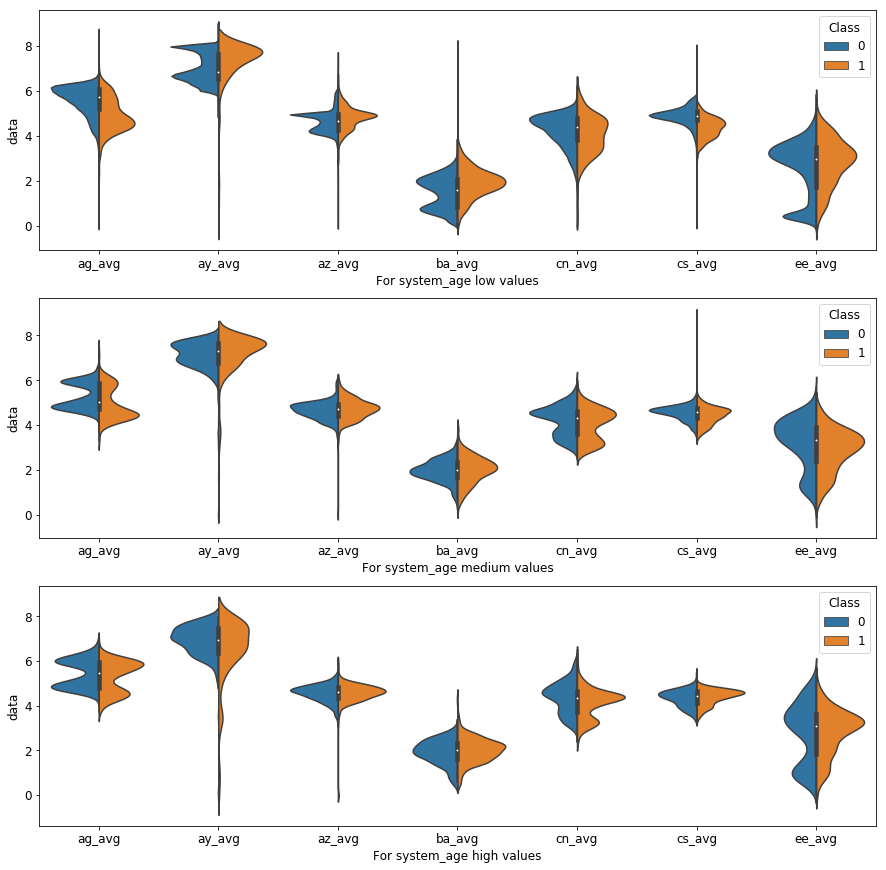

In [29]:
categories_to_display = data.total_cat.cat.categories[1:]
plt.rcParams.update({'font.size': 12})


fig , axs = plt.subplots(len(categories_to_display))
fig.set_figheight(15)
fig.set_figwidth(15)
#sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
for ax,cat in zip(axs,categories_to_display):
    g = sns.violinplot(data=all_avg_vals[all_avg_vals.total_cat==cat]
                  , x="ref",y="data",hue="Class",split=True
                  , ax = ax)
    g.set_xlabel(f"For system_age {cat} values")
#fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');



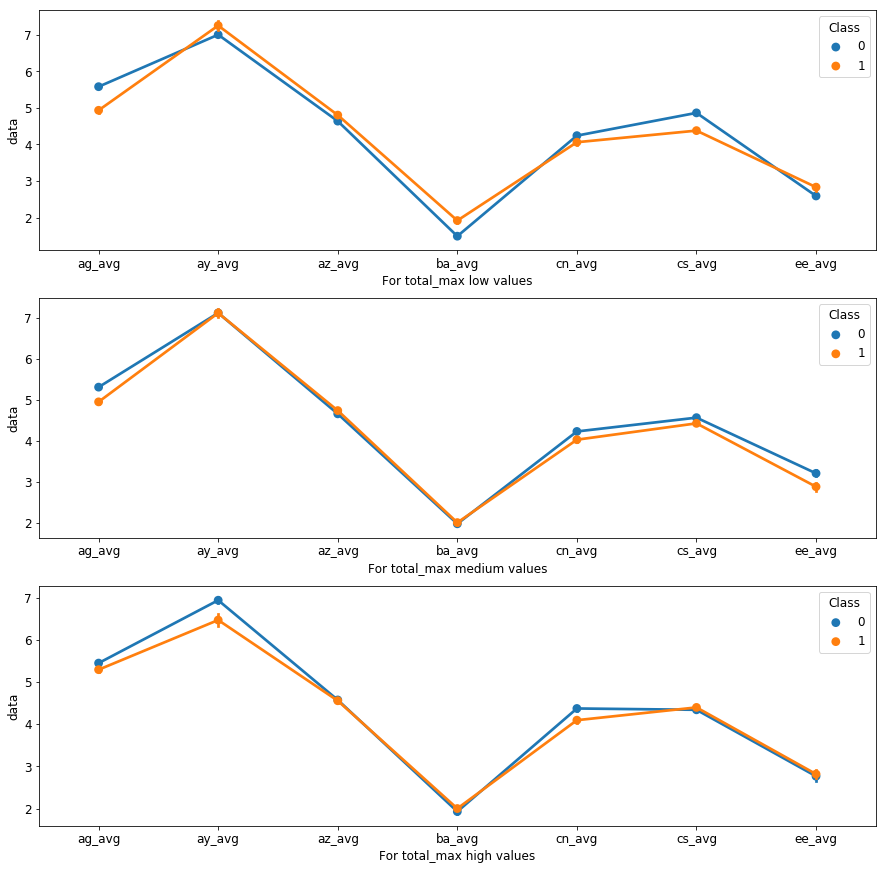

In [30]:
categories_to_diplay = data.total_cat.cat.categories[1:]
fig , axs = plt.subplots(len(categories_to_diplay))
fig.set_figheight(15)
fig.set_figwidth(15)
#sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
for ax,cat in zip(axs,categories_to_diplay):
    g = sns.pointplot(data=all_avg_vals[all_avg_vals.total_cat==cat]
                  , x="ref",y="data",hue="Class"
                  , ax = ax)
    g.set_xlabel(f"For total_max {cat} values")
#fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');

